In [22]:
import random
import numpy as np
import pandas as pd
import time
import re
import json
import datetime
import os
import matplotlib.pyplot as plt
import scipy
from scipy import stats

### Sentences

In [58]:
%%time
sdf = pd.read_excel('data/topic_model_data/fullSentDataFrame_8-1.xlsx',index_col=0)
print(len(sdf))
sdf.head()

58336
CPU times: user 8.75 s, sys: 1.33 s, total: 10.1 s
Wall time: 18.8 s


,index,newsOutlet,category,dateSeen,url,title,language,sourceCountry,sentText,sentIndexInText,sentTopicID
0,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,BRUSSELS (AP) — The European Union is consider...,0,-1
1,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,Acting on a request from Ukraine for help with...,1,-1
2,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,The topic will be discussed during a summit Tu...,2,-1
3,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,The results of the mission have yet to be anal...,3,-1
4,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,One official said the EU’s political and secur...,4,-1


In [59]:
records = sdf.to_dict('records')

In [16]:
import nltk
from nltk import pos_tag, word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('averaged_perceptron_tagger')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentiText
nltk.download('vader_lexicon')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/paigelee/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/paigelee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [60]:
%%time
# add sentiment row to DF
sentiRecs = []
for rec in records:
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(rec['sentText'])
    artSenti = dict()
    for k in ['pos','neu','neg']:
        artSenti[k] = ss[k]
    sentiRecs.append(artSenti)

CPU times: user 5min 45s, sys: 1.96 s, total: 5min 47s
Wall time: 5min 50s


In [182]:
sentOnlyDf = pd.DataFrame.from_records(sentiRecs)
df = pd.concat([sdf, sentOnlyDf],axis=1)
df['dateSeen'] = df['dateSeen'].apply(lambda d: pd.to_datetime(d))
df['sentiVal'] = df['pos']-df['neg']
df.sample(4)

,index,newsOutlet,category,dateSeen,url,title,language,sourceCountry,sentText,sentIndexInText,sentTopicID,pos,neu,neg
34365,1344,tass.com,russian,2022-02-07 08:00:00,https://tass.com/economy/1399243,Gas storages in EU will run out in 6 weeks if ...,English,NaN,"Under such a scenario, Brussels admits that Ru...",17,6,0.148,0.621,0.231
42359,1856,tass.com,russian,2022-01-11 08:00:00,https://tass.com/politics/1386281,"Threats to global security will grow , if Russ...",English,NaN,"They should not avoid this responsibility,"" th...",10,-1,0.167,0.620,0.213
43053,1912,sputniknews.com,russian,2021-12-22 08:00:00,https://sputniknews.com/20211222/western-natio...,Western Nations at UN Warn Russia of Severe C...,English,Russia,Moscow has repeatedly denied those accusations...,9,12,0.083,0.621,0.297
16652,720,reuters.com,western,2021-12-04 08:00:00,https://www.reuters.com/world/ukraine-britain-...,"Ukraine , Britain say they are not trying to u...",English,United States,Ukrainian Defence Ministry/Handout via REUTERS...,1,12,0.211,0.749,0.040


### Write JSON

In [252]:
pwd

'/Users/paigelee/Desktop/summer2022/stanford/research/ukraine-media-CSLI'

In [253]:
jsonDf = df.copy(deep=True)
jsonDf['dateSeen'] = jsonDf['dateSeen'].apply(lambda d : d.timestamp())
del jsonDf['month']
del jsonDf['sourceCountry']

with open('visualizations/histograms/sentData.json', 'w', encoding='utf-8') as f:
    json.dump(jsonDf.to_dict('records'), f, ensure_ascii=False, indent=4)

#### Examples

In [184]:
i = 24
lst = random.sample(df[df['sentTopicID'] == i].to_dict('records'),5)
[print(l['dateSeen'],l['sentText'],'\n') for l in lst]

2021-10-11 07:00:00 One official said the EU’s political and security committee, which is responsible for the common foreign and security policy, will go back to the issue in November. 

2022-01-26 08:00:00 The negotiations proceed slowly and with difficulties," Matviyenko underscored. 

2021-12-22 08:00:00 "Now, from the standpoint of sound cynicism, the negotiations in question look quite telling. 

2022-01-05 08:00:00 The spokeswoman also said that Moscow confirms an upcoming meeting of the Russia-NATO Council on 12 January and 13 January consultations between Russia and the OSCE. 

2022-01-23 08:00:00 "When I approached American journalists [in Geneva], they asked me - the State Department pool: what do we expect from the meeting? 



[None, None, None, None, None]

In [ ]:
# TopicID	Topic Keywords	Topic Summary	Western Count	Western Freq	Russian Count	Russian Freq	MoscowTimes Count	MoscowTimes Freq	Total Count
topicIDs = range(-1,25)
topicStatData = []
for topicID in topicIDs:
    topicRec = dict()
    topicRec['TopicID'] = topicID
    topicRec['Topic Keywords'] = ''
    topicRec['Topic Summary'] = ''
    
    wdf = df[df['category']=='western']
    rdf = df[df['category']=='russian']
    mtdf = df[df['category']=='moscowtimes']
    
    thiswdf = wdf[wdf['sentTopicID']==topicID]
    thisrdf = rdf[rdf['sentTopicID']==topicID]
    thismtdf = mtdf[mtdf['sentTopicID']==topicID]
  
    topicRec['Western Count'] = len(wdf[wdf['sentTopicID']==topicID])
    topicRec['Russian Count'] = len(rdf[rdf['sentTopicID']==topicID])
    topicRec['MoscowTimes Count'] = len(mtdf[mtdf['sentTopicID']==topicID])
    topicRec['Total Count'] = len(df[df['sentTopicID']==topicID])
    
    topicRec['Freq in Western'] = topicRec['Western Count'] / len(wdf)
    topicRec['Freq in Russian'] = topicRec['Russian Count'] / len(rdf)
    topicRec['Freq in MoscowTimes'] = topicRec['MoscowTimes Count'] / len(mtdf)
    topicRec['Total Freq'] = len(df[df['sentTopicID']==topicID])/len(df)
    
    topicRec['Western Senti Avg'] = thiswdf['pos'].mean()- thiswdf['neg'].mean()
    topicRec['Russian Senti Avg'] = thisrdf['pos'].mean() - thisrdf['neg'].mean()
    topicRec['MoscowTimes Senti Avg'] = thismtdf['pos'].mean()- thismtdf['neg'].mean()
    topicRec['Average Senti'] = df[df['sentTopicID']==topicID]['pos'].mean() - df[df['sentTopicID']==topicID]['neg'].mean()
    
    topicStatData.append(topicRec)
    
topicStats = pd.DataFrame.from_records(topicStatData)
topicStats.sample(6)

,TopicID,Topic Keywords,Topic Summary,Western Count,Russian Count,MoscowTimes Count,Total Count,Freq in Western,Freq in Russian,Freq in MoscowTimes,Total Freq,Western Senti Avg,Russian Senti Avg,MoscowTimes Senti Avg,Average Senti
11,10,,,614,592,93,1299,0.024556,0.019708,0.028242,0.022268,0.021373,0.001867,0.003172,0.011180
6,5,,,440,303,49,792,0.017597,0.010087,0.014880,0.013577,0.004782,0.013914,-0.026000,0.006371
4,3,,,203,422,20,645,0.008119,0.014048,0.006073,0.011057,0.016764,0.002455,0.008000,0.007130
21,20,,,587,173,24,784,0.023476,0.005759,0.007288,0.013439,-0.029129,-0.007734,-0.045292,-0.024903
12,11,,,642,249,82,973,0.025676,0.008289,0.024901,0.016679,-0.035072,-0.018040,-0.051073,-0.032062
1,0,,,504,521,62,1087,0.020157,0.017344,0.018828,0.018633,-0.005772,-0.021378,-0.005565,-0.013240


In [165]:
topicStats.to_excel('data/topic_model_data/topics_and_sentiment_8-1.xlsx')

## Timeline data

In [255]:
from datetime import datetime

In [290]:
%%time
# var myData = "date	New York	San Francisco	Austin\n\
# 20111001	63.4	62.7	72.2\n\
timeTuples = [
    ("2021-10-01", "2021-10-15"), 
    ("2021-10-16", "2021-10-31"), 
    ("2021-11-01", "2021-11-15"), 
    ("2021-11-16", "2021-11-30"), 
    ("2021-12-01", "2021-12-15"), 
    ("2021-12-16", "2021-12-31"),    
    ("2022-01-01", "2022-01-15"),    
    ("2022-01-16", "2022-01-31"),
    ("2022-02-01", "2022-02-15"),
    ("2022-02-16", "2022-02-28"),]
records = df.to_dict('records')

biweeklyDict = dict()
recCatCounts = dict()
for rec in records:
    del rec['month']
    if rec['category'] in ['western','russian']:
        # add rec to timerange dict
        for i, (startStr, endStr) in enumerate(timeTuples):
            startDate = datetime.strptime(startStr, '%Y-%m-%d')
            endDate = datetime.strptime(endStr, '%Y-%m-%d')
            if rec['dateSeen'] >= startDate and rec['dateSeen'] <= endDate:
                biweeklyDict.setdefault(i, dict())
                for topicID in range(-1,25):
                    biweeklyDict[i].setdefault(topicID, [])
                biweeklyDict[i][rec['sentTopicID']].append(rec)
                recCatCounts.setdefault(i, {'western' : 0,'russian' : 0})
                recCatCounts[i][rec['category']]+= 1
jsonForTimeline = []
for i in biweeklyDict:
    row = dict()
    row['date'] = timeTuples[i][0].replace('-','')
    row[f'western_ct_period_{i}'] = recCatCounts[i]['western']
    row[f'russian_ct_period_{i}'] = recCatCounts[i]['russian']
    for topicID in range(-1,25):
        row['russian_freq_topic_'+str(topicID)] = len([r for r in biweeklyDict[i][topicID] if r['category']=='russian'])/recCatCounts[i]['russian']
        row['total_freq_topic_'+str(topicID)] = len(biweeklyDict[i][topicID])/(recCatCounts[i]['russian']+recCatCounts[i]['western'])
        row['western_freq_topic_'+str(topicID)] = len([r for r in biweeklyDict[i][topicID] if r['category']=='western'])/recCatCounts[i]['western']
        row['russian_topic_'+str(topicID)] = len([r for r in biweeklyDict[i][topicID] if r['category']=='russian'])
        row['western_topic_'+str(topicID)] = len([r for r in biweeklyDict[i][topicID] if r['category']=='western'])
        row['total_topic_'+str(topicID)] = len(biweeklyDict[i][topicID])
    jsonForTimeline.append(row)

CPU times: user 6.2 s, sys: 171 ms, total: 6.37 s
Wall time: 6.84 s


In [298]:
[t[0].replace('-','') for t in timeTuples]

['20211001',
 '20211016',
 '20211101',
 '20211116',
 '20211201',
 '20211216',
 '20220101',
 '20220116',
 '20220201',
 '20220216']

In [293]:
import json
with open('visualizations/timeline/freq_data.json', 'w', encoding='utf-8') as f:
    json.dump(jsonForTimeline, f, ensure_ascii=False, indent=4)

## Other

### Examples

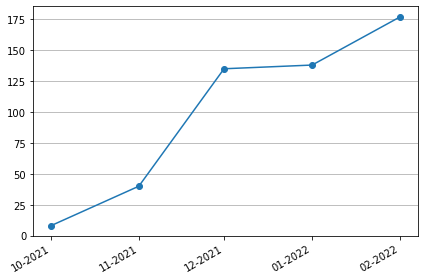

In [238]:
import matplotlib.dates as dates

y = [monthDict[m] for m,y in months]

months = [(10,2021),(11,2021),(12,2021),(1,2022),(2,2022)]
times = [datetime.datetime(y, m, 1) for m,y in months]
fig, ax = plt.subplots(1)
fig.autofmt_xdate()

xfmt = dates.DateFormatter('%m-%Y')
ax.xaxis.set_major_formatter(xfmt)

ax.plot_date(times, y, '-o')
# ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),
#                                             interval=1))
plt.xticks(times)
# ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
plt.tight_layout()
plt.show()

### Article

In [11]:
df = pd.read_excel('data/topic model data/topicArticleFrame7-31.xlsx',index_col=0)
df.sample(5)

FileNotFoundError: [Errno 2] No such file or directory: 'data/topic model data/topicArticleFrame7-31.xlsx'

In [33]:
# TopicID	Topic Keywords	Topic Summary	Western Count	Western Freq	Russian Count	Russian Freq	MoscowTimes Count	MoscowTimes Freq	Total Count
topicCols = [col for col in df.columns if 'topic' in col]
topicStatData = []
for topicCol in topicCols:
    topicRec = dict()
    topicRec['TopicID'] = int(topicCol.split('_')[1])
    topicRec['Topic Keywords'] = ''
    topicRec['Topic Summary'] = ''
    
    topicRec['Western Count'] = df[df['category']=='western'][topicCol].sum()
    topicRec['Freq in Western'] = df[df['category']=='western'][topicCol].sum()/df[df['category']=='western']['sentsInArticle'].sum()
    
    topicRec['Russian Count'] = df[df['category']=='russian'][topicCol].sum()
    topicRec['Freq in Russian'] = df[df['category']=='russian'][topicCol].sum()/df[df['category']=='russian']['sentsInArticle'].sum()
    
    topicRec['MoscowTimes Count'] = df[df['category']=='moscowtimes'][topicCol].sum()
    topicRec['Freq in MoscowTimes'] = df[df['category']=='moscowtimes'][topicCol].sum()/df[df['category']=='moscowtimes']['sentsInArticle'].sum()
    
    topicRec['Total Count'] = df[topicCol].sum()
    topicRec['Total Freq'] = df[topicCol].sum()/df['sentsInArticle'].sum()
    topicStatData.append(topicRec)
    
topicStats = pd.DataFrame.from_records(topicStatData)
topicStats.sample(6)

,TopicID,Topic Keywords,Topic Summary,Western Count,Freq in Western,Russian Count,Freq in Russian,MoscowTimes Count,Freq in MoscowTimes,Total Count,Total Freq
20,19,,,469,0.018757,674,0.022437,22,0.006681,1165,0.019971
13,12,,,792,0.031675,1289,0.042911,148,0.044944,2229,0.038210
11,10,,,138,0.005519,629,0.020939,56,0.017006,823,0.014108
15,14,,,268,0.010718,353,0.011751,148,0.044944,769,0.013182
18,17,,,842,0.033675,699,0.023270,90,0.027331,1631,0.027959
17,16,,,375,0.014998,79,0.002630,49,0.014880,503,0.008622


In [34]:
topicStats.head()

,TopicID,Topic Keywords,Topic Summary,Western Count,Freq in Western,Russian Count,Freq in Russian,MoscowTimes Count,Freq in MoscowTimes,Total Count,Total Freq
0,-1,,,4990,0.199568,5951,0.198109,561,0.170361,11502,0.197168
1,0,,,736,0.029435,685,0.022804,65,0.019739,1486,0.025473
2,1,,,1049,0.041953,1415,0.047105,195,0.059217,2659,0.045581
3,2,,,140,0.005599,213,0.007091,12,0.003644,365,0.006257
4,3,,,534,0.021357,532,0.017710,80,0.024294,1146,0.019645


### Write to Excel

In [35]:
topicStats.to_excel('data/topic model data/topic stats jul 26-2.xlsx')